## Web scraper for burberry.com
#### My goal was to get all the products and prices from burberry's page. First I had to connect to the page, extract the links, and for each link, extract the needed information. After that I thought it's a great opportunity to play with Azure, so I set up an account, and uploaded the data to there. I also tried tqdm package, which is a progress bar, and it's a great help for time consuming tasks like this.

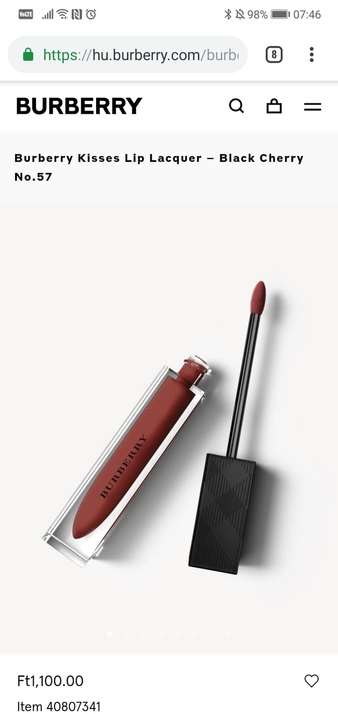

In [1]:
import pandas as pd
import requests
import os
from bs4 import BeautifulSoup
import time
import pyodbc
from tqdm import tqdm_notebook as tqdm # tqdm_notebook for Jupyter

#### First we need a connection to the home page, and extract all the links from it. The soup.find_all('a') is responsible for them.

In [2]:
html = requests.get("https://hu.burberry.com/")
html = html.content
soup = BeautifulSoup(html, 'html.parser')

In [3]:
pages = []

for link in soup.find_all('a'):
    pages.append(link.get('href'))

pages[:10]

['/',
 '/the-monogram-universe/',
 '/women/',
 '/men/',
 '/children/',
 '/bags/',
 '/the-trench-coat/',
 '/search/?q',
 '/burberry/myburberry/overview/myOverview.jsp',
 '/checkout/index.jsp?page=SB']

#### I only need the women, men, and make-up products (in this case the subpages), so I'm making a search for them, and store them in a list called goal.

In [4]:
search_for = ['/women', '/men/', '/make-up/']
goal = []

for i in pages:
    if i is None:
        continue
    elif ('make-up' in i or 'women' in i or 'men' in i) and i not in goal:
        goal.append(i)
        
goal.sort()
goal[:5]

['/customer-service/payment/',
 '/legal-cookies/accessibility-statement/',
 '/legal-cookies/transparency-in-the-supply-chainmodern-slavery-statements/',
 '/make-up-eyes/',
 '/make-up-face/']

In [5]:
print('https://hu.burberry.com' + str(goal[53]))

https://hu.burberry.com/mens-umbrellas/


In [6]:
subpages = []

for i in goal:
    subpages.append('https://hu.burberry.com' + str(i))
    
subpages[:5]

['https://hu.burberry.com/customer-service/payment/',
 'https://hu.burberry.com/legal-cookies/accessibility-statement/',
 'https://hu.burberry.com/legal-cookies/transparency-in-the-supply-chainmodern-slavery-statements/',
 'https://hu.burberry.com/make-up-eyes/',
 'https://hu.burberry.com/make-up-face/']

#### This is the part where I iterate through the subpages, and extract the title and the price of the products. I'm using tqdm, to see the progress, because this takes a few minute, and it's more fun than printing out the actual subpage.

In [7]:
full_list = []

for page in tqdm(subpages):
    html = requests.get(page)
    html = html.content
    soup = BeautifulSoup(html, 'html.parser')
    
    for i,j in zip(soup.find_all('div', {'class' : 'product-card-title'}), 
                   soup.find_all('div', {'class' : 'product-card-price'})):
        if (i and j) not in full_list: 
            j = j.getText(strip=True) # Without stripping it would be filled with '\t\n\n\n'
            j = j[2:] # The prices extracted in Ft10,000.0 format, which I convert to 10000.0
            j = j.replace(',', '')
            full_list.append([i.getText(strip=True), j])
        
    time.sleep(0.4) # A bit of sleep, not to flood the site.
    # print(page)

#### I'm making the burberry_df DataFrame, to load the full_list into it. Dump the few empty rows, and make Price an integer. Sorting to ascending on Price, and resetting the index.

In [8]:
burberry_df = pd.DataFrame(full_list, columns = ['Product' , 'Price']) 
burberry_df = burberry_df[burberry_df['Product'] != ''] #Dobjuk az üres Product sorokat.
burberry_df['Price'] = pd.to_numeric(burberry_df['Price'], downcast='signed') # Tizedesjegyes float-ból csinál int-et.
burberry_df.sort_values(by='Price', inplace=True)
#burberry_df.index.name = 'ID'
#burberry_df.reset_index(inplace=True, drop=True)

In [9]:
burberry_df.head(10)

,Product,Price
0,Burberry Kisses Lip Lacquer – Military Red No.41,1100
1,Burberry Kisses Lip Lacquer – Nude No.03,1100
2,Burberry Kisses Lip Lacquer – Oxblood No.53,1100
3,Burberry Kisses Lip Lacquer – Creamy Rose No.07,1100
51,Nail Polish - Poppy Black No.299,6000
50,Nail Protect Base & Top Coat,6000
49,Nail Polish - Ash Rose No.103,6000
48,Nail Polish - Dusky Mauve No.405,6000
47,Nail Polish - Teal Blue No.427,6000
46,Nail Polish - Military Red No.300,6000


In [10]:
burberry_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3726 entries, 0 to 2525
Data columns (total 2 columns):
Product    3726 non-null object
Price      3726 non-null int32
dtypes: int32(1), object(1)
memory usage: 72.8+ KB


In [11]:
burberry_df.loc[(burberry_df['Price'] > 10000) & (burberry_df['Price'] < 30000)].head(10)

,Product,Price
21,Bold Lash Mascara – Ebony No.01,10500
39,Fresh Glow Highlighting Luminous Pen – Nude Ra...,10500
9,Liquid Lip Velvet – Black Cherry No.57,10500
753,Mr. Burberry Body Wash 250ml,10500
10,Liquid Lip Velvet – Fawn Rose No.09,10500
11,Lip Velvet Rosewood No.421,10500
826,Mr. Burberry Body Wash 250ml,10500
22,Bold Lash Mascara – Chestnut Brown No.02,10500
28,Full Brows - Barley No.01,10500
19,Burberry Cat Lashes – Ultra Black No.01,10500


#### Create a csv file for further use. With index=False we get rid of the 'Unnamed: 0' column.

In [12]:
burberry_df.to_csv('burberry_df.csv', encoding='utf-8', index=False)

## Write the DataFrame to Azure SQL

#### I'd like to try how Azure SQL Database works, so I registered an account. For the connection I had to clear my IP address for it, but after that, it was easy, because I get the entire connection string with one click.

In [13]:
#####################################
### DON'T FORGET TO ADD PASSWORD ###
####################################

conn = pyodbc.connect("""Driver={ODBC Driver 13 for SQL Server};
            Server=tcp:baloghbalazs.database.windows.net,1433;
            Database=Burberry;
            Uid=baloghbalazs@baloghbalazs;
            Pwd=dOHerty88; 
            Encrypt=yes;
            TrustServerCertificate=no;
            Connection Timeout=30;""")

In [14]:
cursor = conn.cursor()
cursor.execute('SELECT TOP 10 * FROM Products_Prices').fetchall()

[(1, 'Test', 2000.0)]

#### Testing with inserting a Test_2 row. It works fine.

In [15]:
cursor.execute("""DELETE FROM Products_Prices WHERE Product = 'Test_2'""")

cursor.execute("""INSERT INTO Products_Prices 
                  VALUES ('Test_2', 2000)""")

cursor.execute('SELECT * FROM Products_Prices').fetchall()

[(1, 'Test', 2000.0), (23090, 'Test_2', 2000.0)]

#### I need tqdm again, to see the progress of the ~3000 rows inserting to the table. I use cursor.execute, not .executemany, because if I want to use tqdm, and inserting together, I have to go row-by-row (.tolist()[i]). Before that, I empty the table.

In [16]:
cursor.execute("""DELETE FROM Products_Prices WHERE ID > 1""")

for i in tqdm(range(burberry_df.shape[0])):
    cursor.execute("""INSERT INTO Products_Prices(Product, Price) VALUES(?,?)""", burberry_df.values.tolist()[i])

#### Let's see, if it worked.

In [17]:
cursor.execute('SELECT TOP 10 * FROM Products_Prices').fetchall()

[(1, 'Test', 2000.0),
 (23091, 'Burberry Kisses Lip Lacquer – Military Red No.41', 1100.0),
 (23092, 'Burberry Kisses Lip Lacquer – Nude No.03', 1100.0),
 (23093, 'Burberry Kisses Lip Lacquer – Oxblood No.53', 1100.0),
 (23094, 'Burberry Kisses Lip Lacquer – Creamy Rose No.07', 1100.0),
 (23095, 'Nail Polish - Poppy Black No.299', 6000.0),
 (23096, 'Nail Protect Base & Top Coat', 6000.0),
 (23097, 'Nail Polish - Ash Rose No.103', 6000.0),
 (23098, 'Nail Polish - Dusky Mauve No.405', 6000.0),
 (23099, 'Nail Polish - Teal Blue No.427', 6000.0)]

#### TODO: Make the inserting faster. // Get all the countries products and prices. Need to extend the table with  Country, Currency, CurrencyHUF, HUF columns, where I can convert the prices realtime, with a currency API (or CurrencyConverter library - https://pypi.org/project/CurrencyConverter/).

In [18]:
html = requests.get("https://hu.burberry.com/")
html = html.content
soup = BeautifulSoup(html, 'html.parser')

In [20]:
for link in soup.find_all('a'):
    print(link.get('href'))

/
/the-monogram-universe/
/women/
/men/
/children/
/bags/
/the-trench-coat/
/search/?q
/burberry/myburberry/overview/myOverview.jsp
/checkout/index.jsp?page=SB
/monogram-collection/
/womens-monogram-collection/
/mens-monogram-collection/
/the-monogram-universe/
/the-monogram-universe/
/a-new-signature/
/womens-new-arrivals-new-in/
/womens-new-arrivals-new-in/
/womens-autumn-pre-collection/
/womens-monogram-collection/
/the-tb-bag-collection/
/silk-prints/
/womens-icon-stripe/
/burberry-kisses-lip-lacquer/
/tennis-whites/
/spring-summer-2019/
/womens-spring-summer-2019-looks/
/womens-spring-summer-2019-collection/
/women-for-you/
/womens-clothing/
/womens-coats-jackets/
/womens-trench-coats/
/womens-coats/
/womens-jackets/
/womens-quilts-puffers/
/womens-ponchos-wraps/
/tailoring/
/dresses/
/womens-knitwear/
/womens-sweatshirts/
/womens-shirts-tops/
/womens-polo-shirts-t-shirts/
/womens-skirts/
/womens-trousers-jeans/
/womens-swimwear/
/womens-bags/
/womens-bags/
/the-tb-bag/
/the-belt-